# Used Cars Database

* https://www.kaggle.com/jayantrag/used-cars-data-explored

### Context:

* This is basically a website which holds the database of all the cars registered for selling.
* Over 370000 used cars scraped with Scrapy from Ebay-Kleinanzeigen.
* The content of the data is in german, so one has to translate it first if one can not speak german.

### Problem Statement:

* This is a regression problem.
* To build a pricing model based on the given dataset.
* Data is collected till the year 2018.

### Overview:

* This dataset has 370000 registries of used cars.
* Each registry consists of information about a single car.

#### Target Variable:

* price: the price on the ad to sell the car

#### Features of data:

* dateCrawled : when this ad was first crawled, all field-values are taken from this date
* name : "name" of the car
* seller : private or dealer
* offerType
* abtest
* vehicleType: Type of the vehicle registered
* yearOfRegistration : at which year the car was first registered
* gearbox: automatic or manual
* powerPS : power of the car in PS
* model: model of the car registered
* kilometer : how many kilometers the car has driven
* monthOfRegistration : at which month the car was first registered
* fuelType: diesel, petrol, etc
* brand: brand of the car registered
* notRepairedDamage : if the car has a damage which is not repaired yet
* dateCreated : the date for which the ad at ebay was created
* nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless
* postalCode
* lastSeenOnline : when the crawler saw this ad last online

# Exploratory Data Analysis

In [32]:
# Pandas for DataFrames
import pandas as pd

# NumPy for numerical computing
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Seaborn for easier visualization
import seaborn as sns

from math import sqrt

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

# Function for splitting training and test set
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge 
from sklearn.svm import SVR

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## import xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor
from xgboost import plot_importance  ## to plot feature importance

from datetime import date

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeRegressor

# To save the final model on disk
from sklearn.externals import joblib  ## Reference http://scikit-learn.org/stable/modules/model_persistence.html

#### Reading the data

In [2]:
df=pd.read_csv("autos.csv", sep=',', header=0, encoding='cp1252')

In [3]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.shape

(371528, 20)

#### some features are numerical and some are categorical

In [5]:
df.dtypes[df.dtypes=="object"]

dateCrawled          object
name                 object
seller               object
offerType            object
abtest               object
vehicleType          object
gearbox              object
model                object
fuelType             object
brand                object
notRepairedDamage    object
dateCreated          object
lastSeen             object
dtype: object

### Distribution of numerical features.

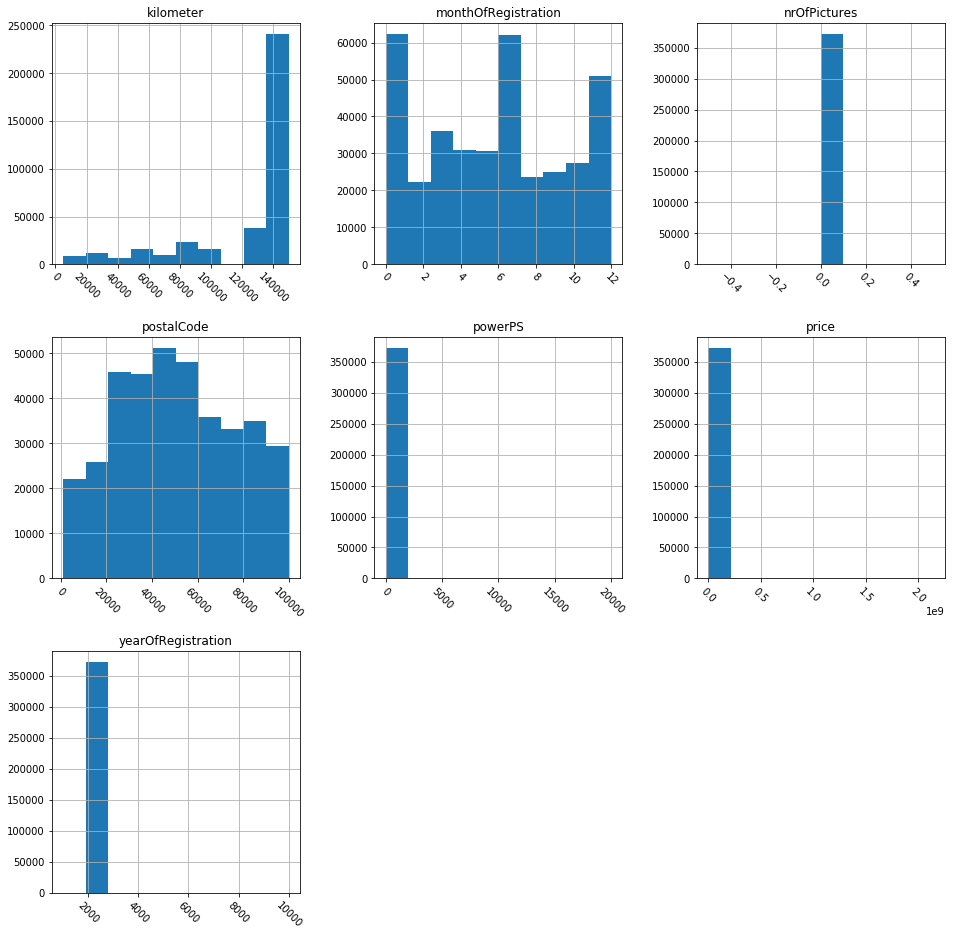

In [6]:
# Plot histogram grid
df.hist(figsize=(16,16), xrot=-45) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()

#### Observations:

* More than 200000 cars have kilometers > 140000. i.e our data has more cars that are old.
* we have less than 50000 cars which have kilometer value less than 140000 which is very scarce.

Take a look at the histagram for month of registration.
* most cars were registered in the month of january, june and december

In [7]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


#### Observations:

* The column yearOfRegistration has values greater than 2018 and minimum value as 1000, which is absurd.
* nrOfPictures has all values as '0'.Hence, this column can be dropped.
* The powerPS column has minimum value '0' and maximum value '20000' which is impossible. 

### Distribution of Categorical features.

In [8]:
df.describe(include=['object'])

,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage,dateCreated,lastSeen
count,371528,371528,371528,371528,371528,333659,351319,351044,338142,371528,299468,371528,371528
unique,280500,233531,2,2,2,8,2,251,7,40,2,114,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,test,limousine,manuell,golf,benzin,volkswagen,nein,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,657,371525,371516,192585,95894,274214,30070,223857,79640,263182,14450,17


In [9]:
df['model'].value_counts()

golf                  30070
andere                26400
3er                   20567
polo                  13092
corsa                 12573
astra                 10830
passat                10306
a4                    10257
c_klasse               8775
5er                    8546
e_klasse               7561
a3                     6604
a6                     6023
focus                  5950
fiesta                 5775
transporter            5528
twingo                 4953
2_reihe                4816
fortwo                 4338
a_klasse               4316
vectra                 4255
1er                    3837
mondeo                 3626
clio                   3553
touran                 3540
3_reihe                3503
punto                  3349
zafira                 3049
megane                 2927
ibiza                  2702
                      ...  
mii                      81
crossfire                66
range_rover_evoque       65
gl                       64
nubira              

#### Observations:

* Columns vehicleType, gearbox, model, fuelType, notRepaired have NaN values.

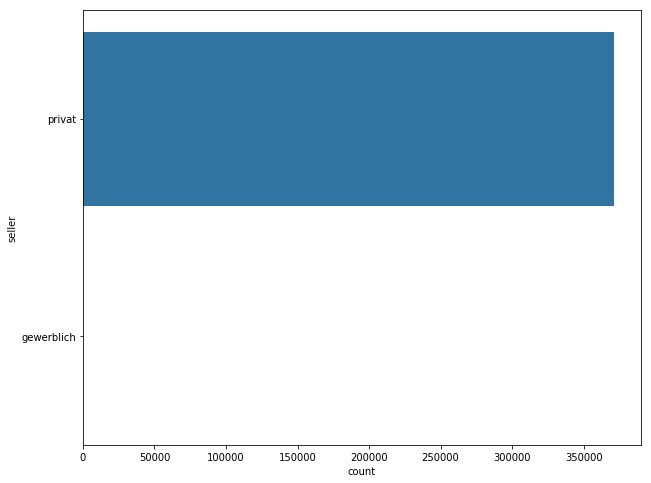

In [10]:
plt.figure(figsize=(10,8))
sns.countplot(y='seller', data=df)

In [11]:
df['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

#### Observations:
* class gewerblich has only 3 occurences.Therefore, it is a sparse class. 

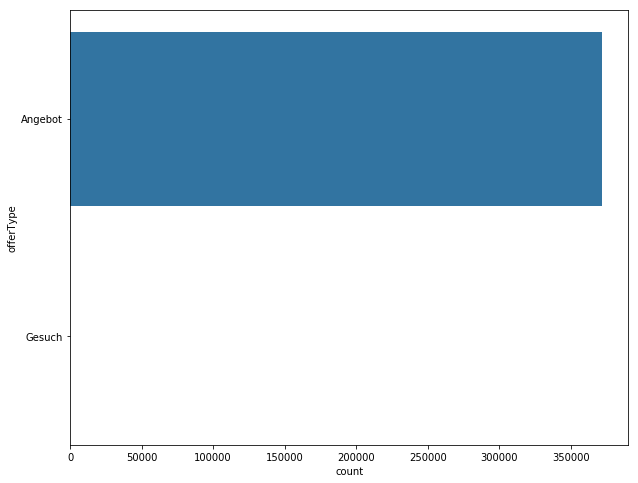

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(y='offerType', data=df)

#### Observations:
* Again the class 'Gesuch' is a sparse class.

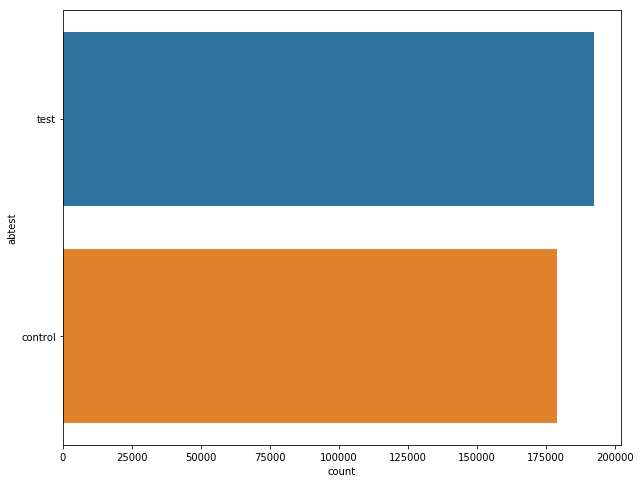

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(y='abtest', data=df)

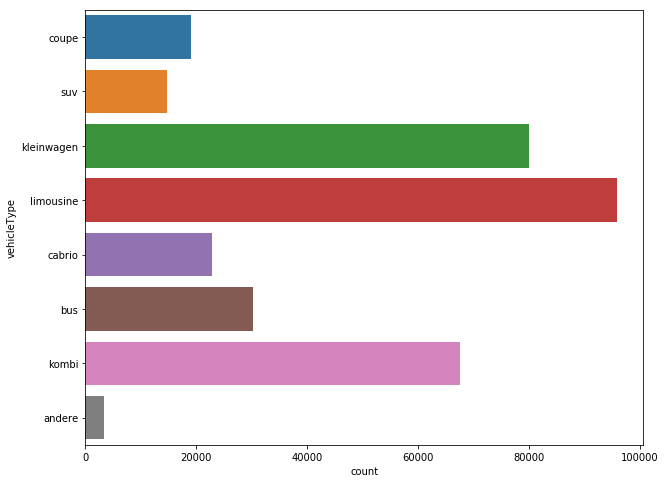

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(y='vehicleType', data=df)

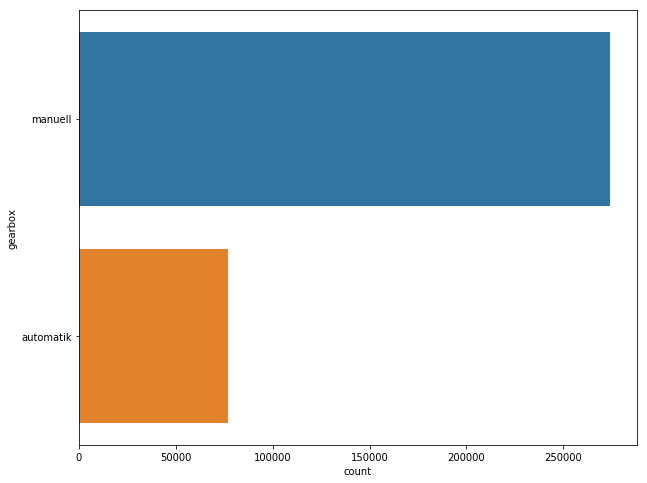

In [15]:
plt.figure(figsize=(10,8))
sns.countplot(y='gearbox', data=df)

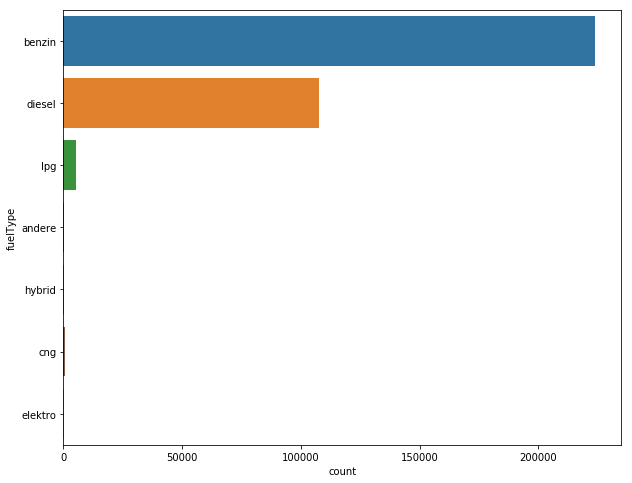

In [15]:
plt.figure(figsize=(10,8))
sns.countplot(y='fuelType', data=df)

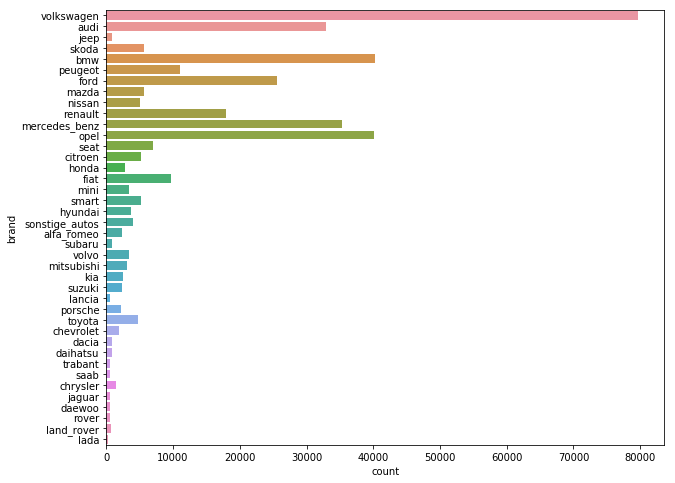

In [16]:
plt.figure(figsize=(10,8))
sns.countplot(y='brand', data=df)

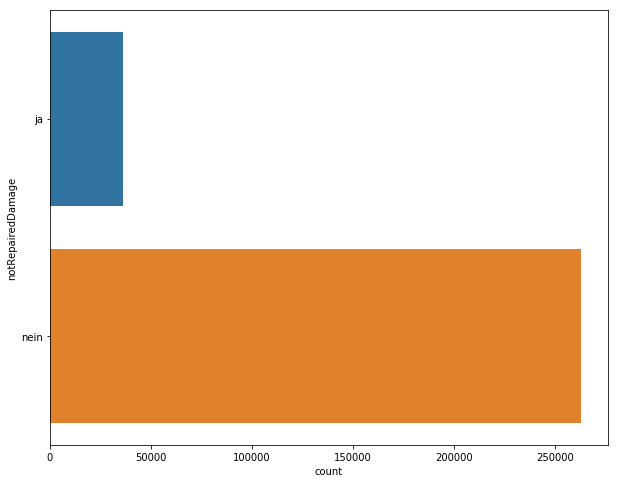

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(y='notRepairedDamage', data=df)

#### Sparse classes need to be dealt with because they can cause the model to overfit.

### Segmentations

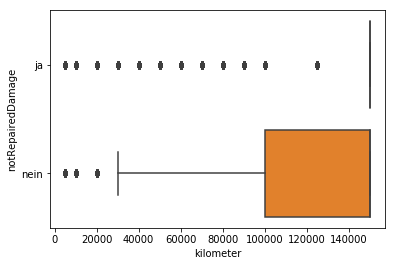

In [18]:
sns.boxplot(y='notRepairedDamage', x='kilometer', data=df)

#### Observations:

* Most old cars are damaged and repaired.
* few newly registered cars are not repaired.

### Correlations

In [19]:
df.corr()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,-0.000182,0.006850,-0.000635,-0.002826,NaN,-0.003164
yearOfRegistration,-0.000182,1.000000,0.000351,-0.055319,-0.011607,NaN,-0.001652
powerPS,0.006850,0.000351,1.000000,-0.010738,0.044358,NaN,0.027113
kilometer,-0.000635,-0.055319,-0.010738,1.000000,0.001838,NaN,-0.026694
monthOfRegistration,-0.002826,-0.011607,0.044358,0.001838,1.000000,NaN,0.014963
nrOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalCode,-0.003164,-0.001652,0.027113,-0.026694,0.014963,NaN,1.000000


#### Observations:

* nrOfPictures has all values NaN as it has standard deviation 0.

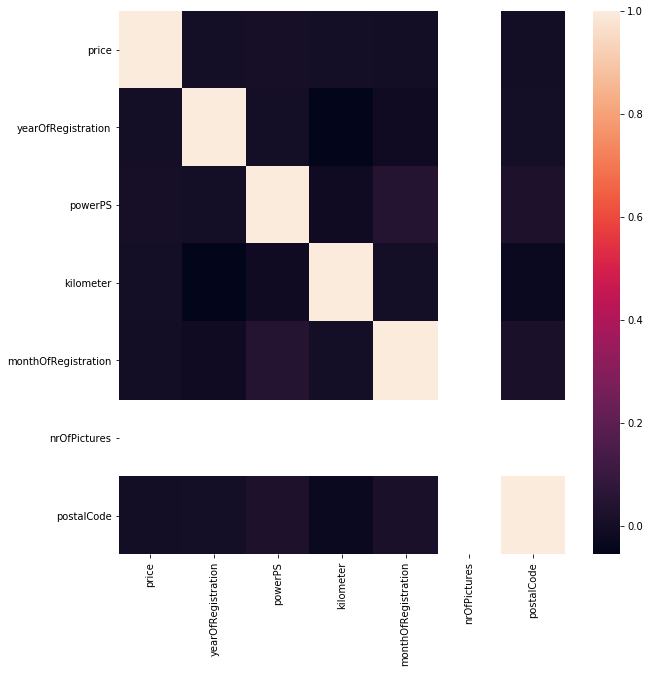

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

In [21]:
df.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.006850
postalCode             0.003164
monthOfRegistration    0.002826
kilometer              0.000635
yearOfRegistration     0.000182
nrOfPictures                NaN
Name: price, dtype: float64

* power is the most influencing feature for predicting price.

### Data Cleaning

#### Dropping duplicates

In [16]:
df=df.drop_duplicates()

In [17]:
df.shape

(371524, 20)

there were 4 duplicates in our data.

#### Removing outliers 

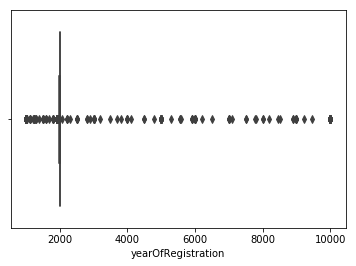

In [39]:
sns.boxplot(df.yearOfRegistration)

this column has values less than 1980 and 2018 which can be considered as outliers.

In [18]:
df=df[df.yearOfRegistration<2018]

In [19]:
df=df[df.yearOfRegistration>1980]

In [20]:
df.shape

(362642, 20)

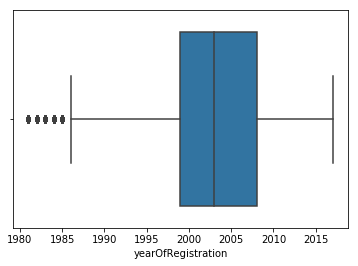

In [43]:
sns.boxplot(df.yearOfRegistration)

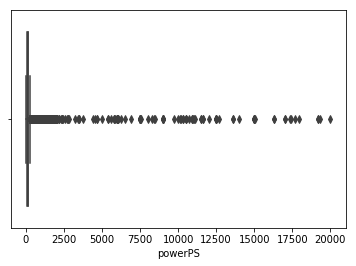

In [44]:
sns.boxplot(df.powerPS)

In [21]:
df=df[df.powerPS<500]

In [22]:
df=df[df.powerPS>0]

In [47]:
df.shape

(323559, 20)

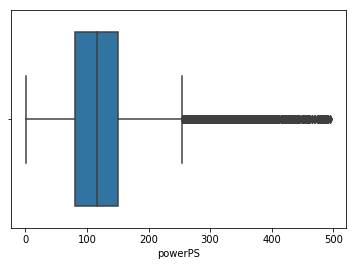

In [48]:
sns.boxplot(df.powerPS)

In [23]:
df.loc[df.price > 160000].count()['name']

87

In [24]:
df=df[(df.price>100)&(df.price<160000)]

In [25]:
df.shape

(314998, 20)

#### Checking null values in Categorical Data

In [26]:
df.select_dtypes(include=['object']).isnull().sum()

dateCrawled              0
name                     0
seller                   0
offerType                0
abtest                   0
vehicleType          18101
gearbox               5683
model                11823
fuelType             18151
brand                    0
notRepairedDamage    45430
dateCreated              0
lastSeen                 0
dtype: int64

In [27]:
df['vehicleType'] = df['vehicleType'].fillna('Missing')
df['gearbox'] = df['gearbox'].fillna('Missing')
df['model'] = df['model'].fillna('Missing')
df['fuelType'] = df['fuelType'].fillna('Missing')
df['notRepairedDamage'] = df['notRepairedDamage'].fillna('Missing')

In [28]:
df.select_dtypes(include=['object']).isnull().sum()

dateCrawled          0
name                 0
seller               0
offerType            0
abtest               0
vehicleType          0
gearbox              0
model                0
fuelType             0
brand                0
notRepairedDamage    0
dateCreated          0
lastSeen             0
dtype: int64

#### Checking null values in Numerical Data.

In [29]:
df.select_dtypes(exclude=['object']).isnull().sum()

price                  0
yearOfRegistration     0
powerPS                0
kilometer              0
monthOfRegistration    0
nrOfPictures           0
postalCode             0
dtype: int64

### Feature Engineering

#### Dropping useless features.

* The following features have no relevance for the given problem.Hence, dropping these features.

In [30]:
df.reset_index(drop=True,inplace=True)

In [31]:
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis=1, inplace=True)

In [32]:
df.shape

(314998, 12)

#### Handling sparse classes.

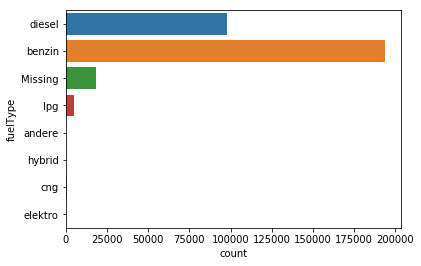

In [46]:
sns.countplot(y='fuelType', data=df)

In [33]:
df.fuelType.replace(['andere', 'hybrid', 'cng', 'elektro', 'lpg'], 'andere', inplace=True)

* "andere" is a German word which means "others" in English

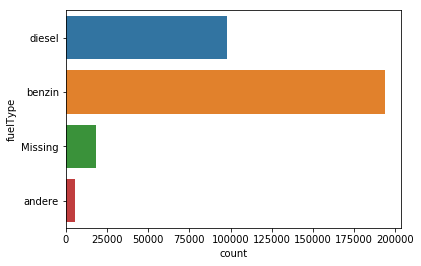

In [48]:
sns.countplot(y='fuelType', data=df)

#### Indicator Varibles.

In [49]:
df.kilometer.value_counts()

150000    202118
125000     33667
100000     13598
90000      11182
80000       9943
70000       8839
60000       7944
50000       6921
40000       5863
30000       5405
20000       4855
5000        3206
10000       1546
Name: kilometer, dtype: int64

In [34]:
df['Too_new_cars'] = ((df.kilometer <= 5000) & (df.yearOfRegistration >= 2005)).astype(int)

In [35]:
df[df['Too_new_cars']==1].shape[0]/df.shape[0]

0.00487622143632658

0.49% of the data has all new cars.

In [36]:
df.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.584788
yearOfRegistration     0.456085
kilometer              0.450105
Too_new_cars           0.098411
monthOfRegistration    0.049187
Name: price, dtype: float64

* Our new features are influencing the price quite well. :D
* We also created column "cars_with_low_PS" but it was not helping much.Hence we dropped it.

#### Saving DataFrame.

In [37]:
df.to_csv('new_autos.csv', index=None)

In [2]:
df=pd.read_csv("new_autos.csv")

In [3]:
df.head()

,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,Too_new_cars
0,A5_Sportback_2.7_Tdi,18300,coupe,2011,manuell,190,Missing,125000,5,diesel,audi,ja,0
1,"Jeep_Grand_Cherokee_""Overland""",9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,Missing,0
2,GOLF_4_1_4__3TÜRER,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0
3,Skoda_Fabia_1.4_TDI_PD_Classic,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,0
4,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,0


### One Hot Encoding.

In [4]:
df.describe(include='object')

,name,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
count,314998,314998,314998,314998,314998,314998,314998
unique,192595,9,3,250,4,40,3
top,BMW_318i,limousine,manuell,golf,benzin,volkswagen,nein
freq,620,86052,240153,26287,193538,67786,240686


In [5]:
df = pd.get_dummies(df, columns=['vehicleType', 'gearbox', 'fuelType','notRepairedDamage','brand','model'])

In [6]:
pd.set_option('display.max_columns', 500) ## display max 100 columns
df.head()

,name,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,Too_new_cars,vehicleType_Missing,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,gearbox_Missing,gearbox_automatik,gearbox_manuell,fuelType_Missing,fuelType_andere,fuelType_benzin,fuelType_diesel,notRepairedDamage_Missing,notRepairedDamage_ja,notRepairedDamage_nein,brand_alfa_romeo,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,model_100,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_Missing,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_andere,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_discovery_sport,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_t

In [7]:
df.head()

,name,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,Too_new_cars,vehicleType_Missing,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,gearbox_Missing,gearbox_automatik,gearbox_manuell,fuelType_Missing,fuelType_andere,fuelType_benzin,fuelType_diesel,notRepairedDamage_Missing,notRepairedDamage_ja,notRepairedDamage_nein,brand_alfa_romeo,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,model_100,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_Missing,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_andere,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_discovery_sport,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_t

In [8]:
df.drop(['model_serie_2','model_rangerover','model_discovery_sport'],axis=1,inplace=True)

## Machine Learning Models.

In [9]:
#Taking a sample of 100000 points.
df1=df.sample(n=100000,random_state=123)

In [10]:
df1.shape

(100000, 313)

In [11]:
y=df1.price
X=df1.drop(['name','price'], axis=1)

#### Test Train split

In [12]:
# preforming a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 311) (30000, 311) (70000,) (30000,)


# Machine Learning Models

## Model 1:- Baseline Model

In [96]:
## Predict Train results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [97]:
## Predict Test results
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [98]:
print("Train Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Baseline Model:
*******************************
Root mean squared error:  7756.249732091287
R-squared:  0.0
Mean Absolute Error:  5080.210913412245


In [99]:
print("Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Results for Baseline Model:
*******************************
Root mean squared error:  7794.551004247648
R-squared:  -1.0947253745730023e-05
Mean Absolute Error:  5072.838554570476


## Model 2:- Ridge Regression

In [100]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Ridge(), tuned_params, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [101]:
model.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [102]:
y_train_pred = model.predict(X_train)

In [103]:
y_pred = model.predict(X_test)

In [104]:
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  4112.518134230663
R-squared:  0.7188668334572529
Mean Absolute Error:  2443.7168538674987


In [105]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  4106.614304527822
R-squared:  0.7224185890073661
Mean Absolute Error:  2432.6412981520016


### Feature Importance

* We are taking 1 lakh data points for Train and Test as data is big.

In [106]:
model = Ridge(alpha=100000)
model.fit(X_train, y_train)

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [107]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
fuelType_diesel
yearOfRegistration
fuelType_benzin
notRepairedDamage_nein
brand_volkswagen
vehicleType_Missing
notRepairedDamage_ja
vehicleType_kombi
vehicleType_cabrio
brand_porsche
powerPS
notRepairedDamage_Missing
vehicleType_suv
fuelType_Missing
model_transporter
vehicleType_limousine
vehicleType_bus
model_911
brand_opel
gearbox_automatik
brand_ford
brand_audi
gearbox_manuell
vehicleType_kleinwagen
model_golf
model_polo
vehicleType_coupe
model_x_reihe
brand_renault
model_5er
fuelType_andere
model_Missing
brand_peugeot
model_3er
monthOfRegistration
model_vectra
model_a6
model_astra
model_a5
model_mondeo
model_corsa
brand_alfa_romeo
brand_hyundai
brand_land_rover
model_focus
brand_mazda
model_1er
gearbox_Missing
model_2_reihe
model_q5
model_c_klasse
model_clk
model_7er
model_omega
brand_fiat
model_zafira
brand_bmw
model_tiguan
brand_mitsubishi
model_a3
model_passat
brand_chevrolet
model_e_klas

## Model 3:- XGBoost Regression 

In [31]:
# This will take 1 hour.
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [15]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [16]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [17]:
## Predict Test results
y_pred = model.predict(X_test)

### Feature Importance

In [18]:
## Building the model again with the best hyperparameters
model = XGBRegressor(max_depth=4,learning_rate=0.1,n_estimators=400, reg_lambda=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

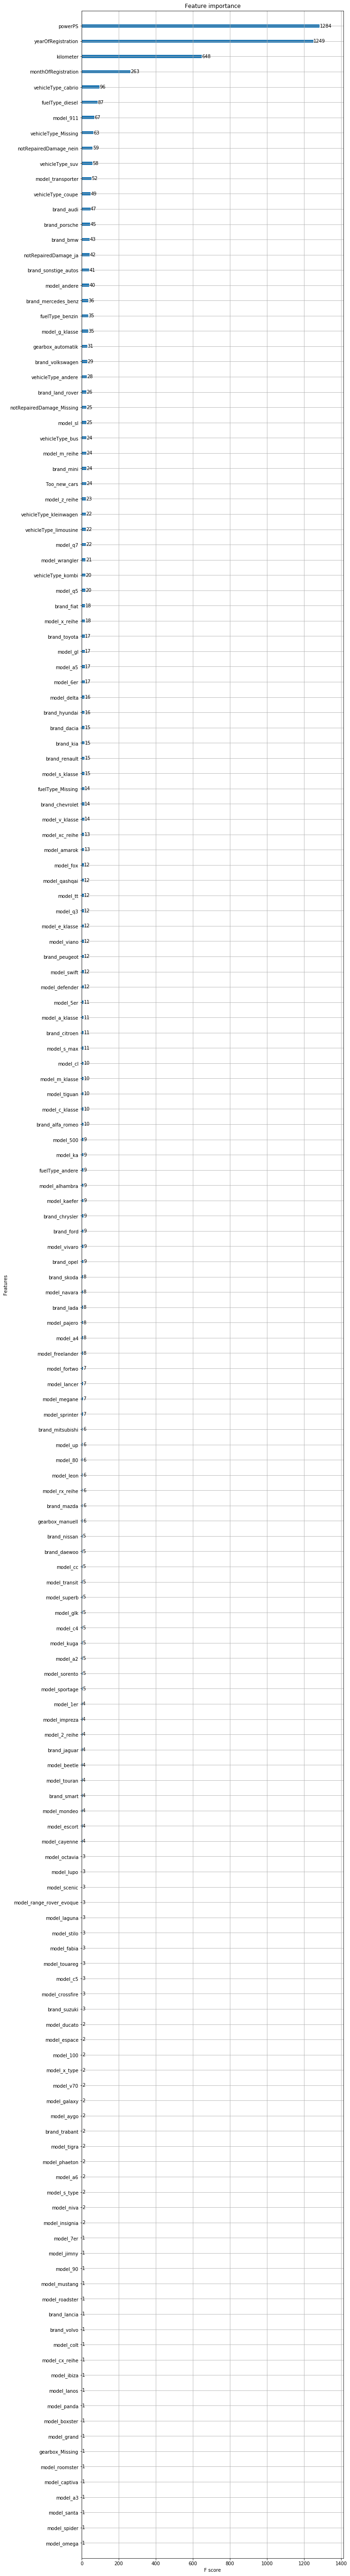

In [22]:
my_plot_importance(model, (10,100))

In [23]:
print("Train Results for XGBoost Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for XGBoost Regression:
*******************************
Root mean squared error:  2079.449633539084
R-squared:  0.9281224535755649
Mean Absolute Error:  1169.1269005173845


In [24]:
print("Test Results for XGBoost Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for XGBoost Regression:
*******************************
Root mean squared error:  2560.1686676234135
R-squared:  0.8921153382546738
Mean Absolute Error:  1263.1291271894852


## Model 4 :- Regression Tree

In [25]:
model3 = DecisionTreeRegressor(criterion = "mse", random_state = 123,
                               max_depth=3, min_samples_leaf=5)
model3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best')

In [26]:
y_pred = model3.predict(X_test)
y_pred

array([ 2685.54498437,  2685.54498437, 18019.97832301, ...,
        6332.91913898, 12258.12897029,  2685.54498437])

In [27]:
y_train_pred = model3.predict(X_train)

In [28]:
print("Train Results for Regression Tree :")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Regression Tree :
*******************************
Root mean squared error:  5064.733420454639
R-squared:  0.5736074429568103
Mean Absolute Error:  3024.910459031512


In [29]:
print("Test Results for Regression Tree :")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Regression Tree :
*******************************
Root mean squared error:  5113.214038874622
R-squared:  0.5696612112520926
Mean Absolute Error:  3032.9075194843767


## Save the winning model to disk

In [30]:
win_model =XGBRegressor(max_depth=4,learning_rate=0.1,n_estimators=400, reg_lambda=0.1)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'Used_Car_winner.pkl') 

['Used_Car_winner.pkl']

## Observation
* Our winning model is XGBoost as it has less errors.


![title](Errors.png)